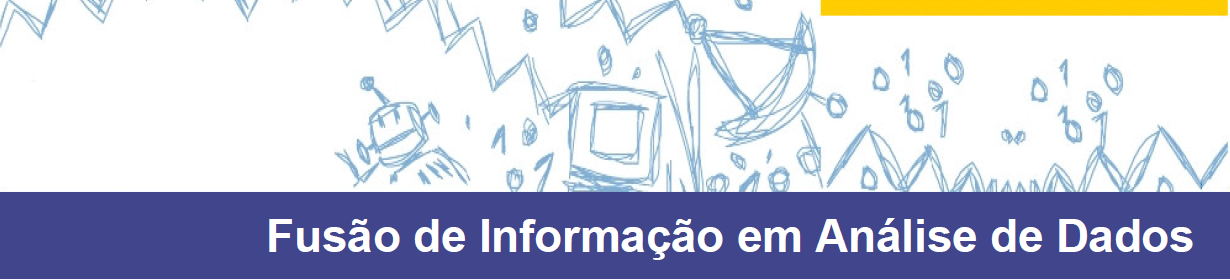
### Ficha Prática nº 4 de FIAD 2022 - Estrutura da Resolução usando Python
Alberto Cardoso e Jorge Henriques © DEI2021/2022

Objetivo: Pretende-se exemplificar a aplicação da fusão de dados de sensores para obter a estimativa da localização de um robot, usando um filtro de Kalman estendido.

**Exercícios**

In [31]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [32]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

In [33]:
def observation(xTrue, xd, u):

    xTrue = motion_model(xTrue, u)

    # add noise to GPS x-y
    zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
    zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
    z = np.array([[zx, zy]])

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Input_Noise[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Input_Noise[1, 1]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

**1.** Criar uma função que implementa o modelo dinâmico do robot.

In [34]:
def motion_model(x, u):
    F = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
    ])

    B = np.array([
        [np.cos(x[2])[0], 0],
        [np.sin(x[2])[0], 0],
        [0, dt],
        [1, 0],
    ])
    
    x = F.dot(x) + B.dot(u)
    
    return x

**2.** Criar uma função que implementa o modelo de observação.

In [35]:
def observation_model(x):
    H = np.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0]
    ], dtype=float)
    
    z = H @ x
    return z

**4.** Criar uma função que implementa o Filtro de Kalman estendido (EKF).

In [55]:

def jacobF(x, u):
    v = u[0]#[0]
    phi = x[2]#[0]

    # Jacobian of Motion Model
    jF = np.array([
        [1.0, 0.0, -v * np.sin(phi) * dt, np.cos(phi) * dt],
        [1.0, 0.0, v * np.cos(phi) * dt, np.sin(phi) * dt],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ], dtype=float)

    return jF

In [56]:
def jacobH(x):
    # Jacobian of Observation Model
    jH = np.array([
        [1.0,0.0,0.0,0.0],
        [0.0,1.0,0.0,0.0]
    ])

    return jH


In [57]:
I = np.array([
             [1,0,0,0],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1]
            ])
'''
Pt é a matriz de covariação do estado no instante t,
Q é a matriz de covariância do ruído do sistema,
R é a matriz de covariância do ruído de observação.
'''

def ekf_estimation(xEst, PEst, z, u):
    
    # Predict
    xPred = motion_model(xEst, u)
    P_Pred = jacobF(xEst, u) @ PEst @ jacobF(xEst, u).T + Q

    # Update
    jacobiana = jacobH(xPred)
    zPred = observation_model(xEst)
    y = z.T - zPred
    S = jacobiana @ P_Pred @ jacobiana.T + R
    S = S.astype(float)
    S_inv = np.linalg.inv(S)
    K = P_Pred @ jacobiana.T @ S_inv
    xEst = xPred + K @ y
    PEst = (np.eye(len(xEst)) - K @ jacobiana) @ P_Pred
    
    return xEst, PEst

In [58]:
def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

**5.** Especificar os vários parâmetros do filtro e de simulação do robot.

In [59]:
# Estimation parameters of EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
R = np.diag([1.0, 1.0])**2  # Observation x,y position covariance

#  Simulation parameter
GPS_Noise = np.diag([0.5, 0.5])**2
Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

show_animation = True

**6.** Simular o movimento do robot e representar dinamicamente a sua localização, considerando as trajetórias e a elipse indicadas no enunciado do trabalho.

In [60]:
%matplotlib notebook

def main():
    print("Robot simulation start!")

    time = 0.0

    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((1, 2))

    fig = plt.figure()
    fig.show()
    
    while SIM_TIME >= time:
        time += dt
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u)

        xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.vstack((hz, z))

        if show_animation:
            plt.cla()
            plt.plot(hz[:, 0], hz[:, 1], ".g")
            plt.plot(hxTrue[0, :].flatten(),
                     hxTrue[1, :].flatten(), "-b")
            plt.plot(hxDR[0, :].flatten(),
                     hxDR[1, :].flatten(), "-k")
            plt.plot(hxEst[0, :].flatten(),
                     hxEst[1, :].flatten(), "-r")
            plot_covariance_ellipse(xEst, PEst)
            plt.axis("equal")
            plt.grid(True)
            fig.canvas.draw()
            plt.pause(0.001)

Robot simulation start!


<IPython.core.display.Javascript object>


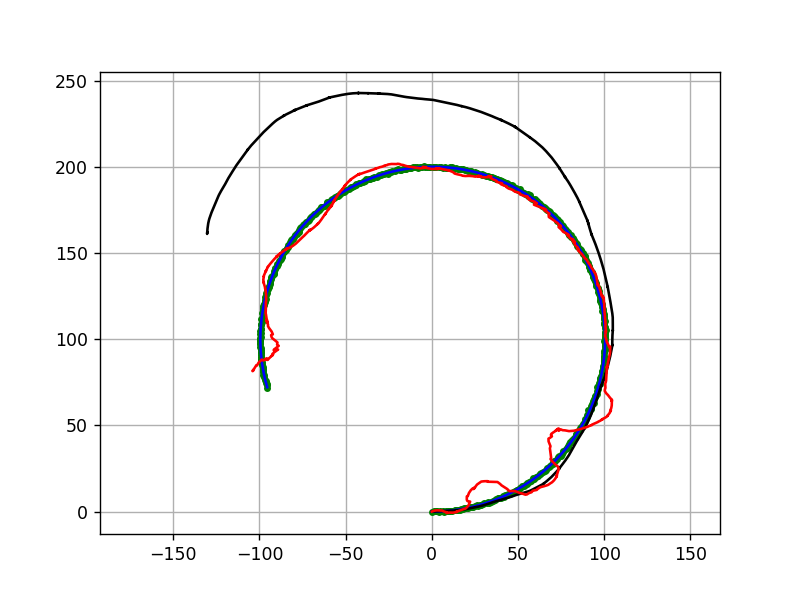

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  jF = np.array([
C:\Users\gouve\AppData\Local\Temp/ipykernel_2152/3250836145.py:6: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])]

In [61]:
main()
# Na figura, a linha azul é a trajetória verdadeira, 
# a linha preta é a trajetória por posicionamento relativo (dead-reckoning),
# os pontos verdes correspondem à observação do posicionamento do robot (por ex. GPS)
# e a linha vermelha é a trajetória estimada com o EKF.
# A elipse vermelha a tracejado representa a elipse de covariância estimada com o EKF.